In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time

%matplotlib inline

In [2]:
cv.__version__

'4.2.0'

In [3]:
# Both config and weights need to be from a 3-channel generated model
file_config = "yolov3-voc.cfg"
file_weights = "yolov3-voc_best.weights"

In [4]:
# Load the weights and configutation to form the pretrained YOLOv3 model
net = cv.dnn.readNetFromDarknet(file_config, file_weights)

In [5]:
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]


In [6]:
# Get the labels
labels = [
        "textbox",
        "textline",
        "checkbox"
         ]


In [7]:
colors = [
    #textbox - burnt orange
    [204,85,0],
    #textline - neon pink
    [254,1,154],
    #checkbox - royal blue
    [0,35,102]
]

In [8]:
def draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels):
    # If there are any detections
    if len(idxs) > 0:
        for i in idxs.flatten():
            # Get the bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # Get the unique color for this class
            color = [int(c) for c in colors[classids[i]]]

            # Draw the bounding box rectangle and label on the image
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)
            text = "{}:{:.1f}".format(labels[classids[i]], 100*confidences[i])
            #text = "{:.1f}".format(100*confidences[i])
            cv.putText(img, text, (x, y-3), cv.FONT_HERSHEY_COMPLEX, 0.7, [255, 255, 255], 4)
            cv.putText(img, text, (x, y-3), cv.FONT_HERSHEY_COMPLEX, 0.7, color, 2)
    return img


def generate_boxes_confidences_classids(outs, height, width, tconf):
    boxes = []
    confidences = []
    classids = []

    for out in outs:
        for detection in out:
            # Get the scores, classid, and the confidence of the prediction
            scores = detection[5:]
            classid = np.argmax(scores)
            confidence = scores[classid]

            # Consider only the predictions that are above a certain confidence level
            if confidence > tconf:
                box = detection[0:4] * np.array([width, height, width, height])
                centerX, centerY, bwidth, bheight = box.astype('int')

                # Using the center x, y coordinates to derive the top
                # and the left corner of the bounding box
                x = int(centerX - (bwidth / 2))
                y = int(centerY - (bheight / 2))

                print("x: %s, width: %s " % (x, int(bwidth)) )
                print("y: %s, width: %s "% (y, int(bheight)) )
                # Append to list
                boxes.append([x, y, int(bwidth), int(bheight)])
                confidences.append(float(confidence))
                classids.append(classid)

    return boxes, confidences, classids

In [9]:
def infer_image(net, layer_names, height, width, img, colors, labels,
            boxes=None, confidences=None, classids=None, idxs=None, infer=True):
    
    confidence = 0.40 # Change this to a lower value to get more detections where the model is less confident
    threshold = 0.1

    if infer:
        # Contructing a blob from the input image
        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
                        swapRB=True, crop=False)

        # Perform a forward pass of the YOLO object detector
        net.setInput(blob)

        # Getting the outputs from the output layers
        start = time.time()
        outs = net.forward(layer_names)
        end = time.time()


        print (" YOLOv3 took {:6f} seconds".format(end - start))


        # Generate the boxes, confidences, and classIDs
        boxes, confidences, classids = generate_boxes_confidences_classids(outs, height, width, confidence)

        # Apply Non-Maxima Suppression to suppress overlapping bounding boxes
        idxs = cv.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

    if boxes is None or confidences is None or idxs is None or classids is None:
        raise '[ERROR] Required variables are set to None before drawing boxes on images.'

    # Draw labels and boxes on the image
    img = draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels)

    return img, boxes, confidences, classids, idxs

In [10]:
def detect(image_filename):
    img = cv.imread(image_filename,cv.IMREAD_COLOR)

    try:
        height, width = img.shape[:2]
    except:
        return
    
    
    print(height,"x",width)
    if height <= 400:
        print("Not even trying for small image")
        return
    
    # Original Image
    #plt.rcParams["figure.figsize"] = (30, 20) # (w, h)
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    #plt.imshow(img)
    
    # Do the detection
    frame, boxes, confidences, classids, idxs = infer_image(net, layer_names, height, width, img, colors, labels)
    
    [print("Confidence: %.2f" % x) for x in confidences]
    print("Class IDs: %s" % classids)
    
    # Show detected image
    plt.rcParams["figure.figsize"] = (30, 20) # (w, h)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.imshow(frame)
    plt.show()

1599 x 1725
 YOLOv3 took 1.324225 seconds
x: 606, width: 564 
y: 108, width: 59 
x: 372, width: 426 
y: 196, width: 74 
x: 1093, width: 420 
y: 193, width: 76 
x: 261, width: 520 
y: 309, width: 63 
x: 642, width: 783 
y: 375, width: 58 
x: 1234, width: 307 
y: 120, width: 44 
x: 359, width: 457 
y: 213, width: 50 
x: 1046, width: 523 
y: 214, width: 50 
x: 186, width: 672 
y: 327, width: 39 
x: 1011, width: 256 
y: 326, width: 37 
x: 58, width: 228 
y: 1331, width: 51 
x: 58, width: 224 
y: 1393, width: 53 
x: 1216, width: 369 
y: 1559, width: 37 
Confidence: 0.96
Confidence: 0.88
Confidence: 0.73
Confidence: 0.79
Confidence: 0.97
Confidence: 0.90
Confidence: 0.71
Confidence: 0.75
Confidence: 0.42
Confidence: 0.73
Confidence: 0.73
Confidence: 0.82
Confidence: 0.56
Class IDs: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


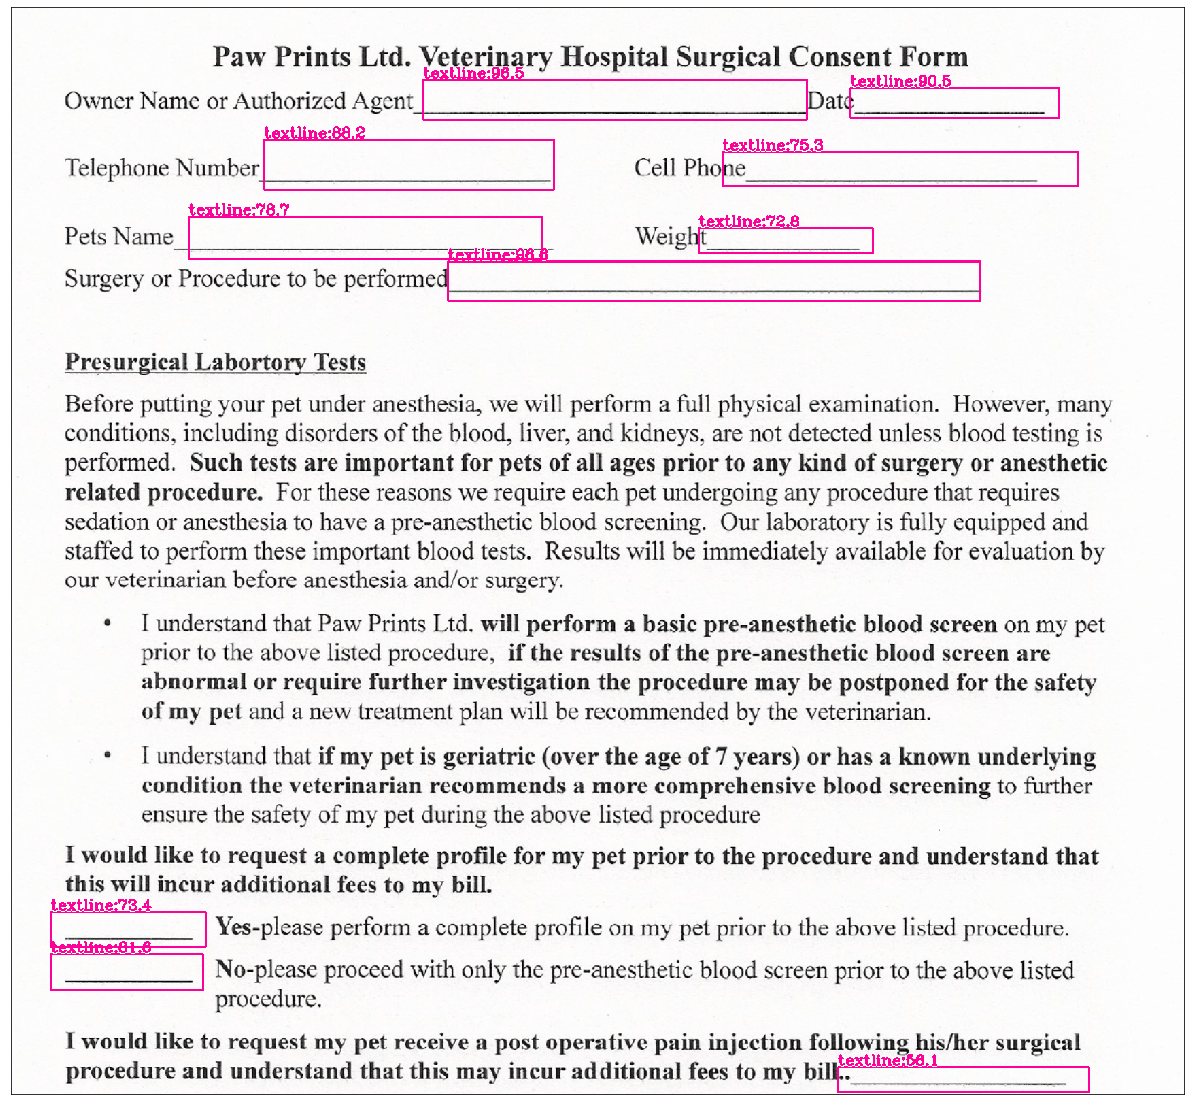

In [11]:
detect("42.png")

665 x 1435
 YOLOv3 took 1.158349 seconds
x: 21, width: 54 
y: 126, width: 44 
x: 19, width: 58 
y: 220, width: 43 
x: 21, width: 54 
y: 318, width: 43 
x: 22, width: 54 
y: 412, width: 42 
x: 22, width: 52 
y: 509, width: 44 
x: 20, width: 57 
y: 603, width: 43 
Confidence: 0.86
Confidence: 0.85
Confidence: 0.91
Confidence: 0.88
Confidence: 0.88
Confidence: 0.88
Class IDs: [2, 2, 2, 2, 2, 2]


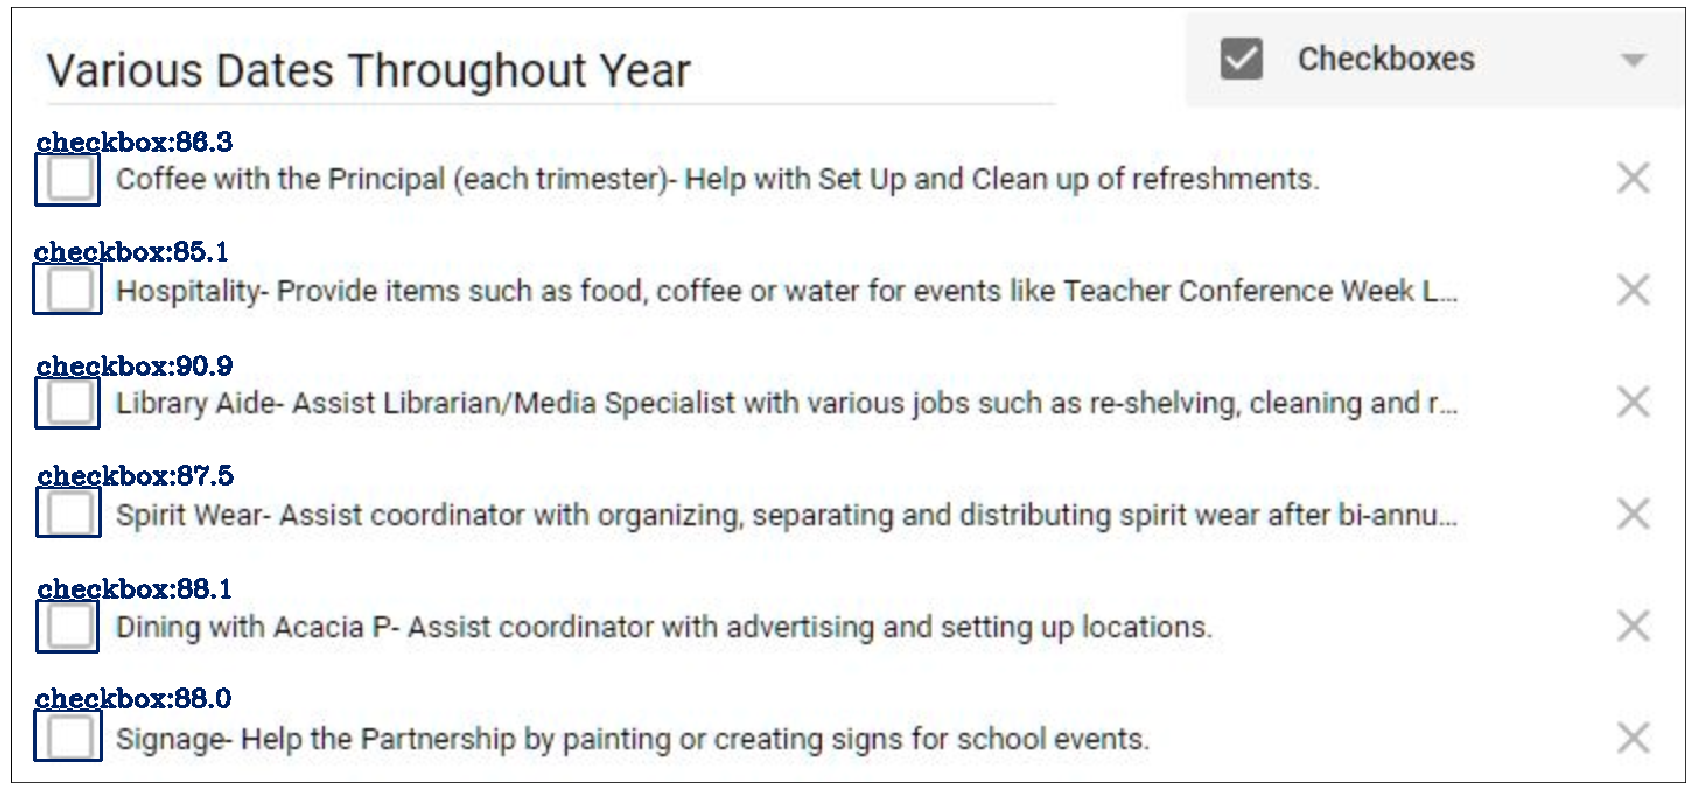

In [12]:
detect("46.png")

1650 x 1275
 YOLOv3 took 0.819819 seconds
x: 92, width: 343 
y: 952, width: 83 
x: 86, width: 15 
y: 246, width: 37 
x: 521, width: 110 
y: 240, width: 39 
x: 738, width: 128 
y: 239, width: 37 
x: 87, width: 16 
y: 288, width: 36 
x: 357, width: 131 
y: 289, width: 40 
x: 614, width: 167 
y: 286, width: 41 
x: 976, width: 64 
y: 287, width: 38 
x: 87, width: 14 
y: 313, width: 32 
x: 87, width: 14 
y: 341, width: 37 
x: 394, width: 129 
y: 340, width: 40 
x: 570, width: 18 
y: 345, width: 28 
x: 865, width: 126 
y: 340, width: 42 
x: 87, width: 15 
y: 381, width: 35 
x: 87, width: 15 
y: 411, width: 34 
x: 87, width: 15 
y: 442, width: 35 
x: 363, width: 124 
y: 447, width: 37 
x: 781, width: 214 
y: 441, width: 46 
x: 86, width: 16 
y: 467, width: 36 
x: 373, width: 117 
y: 466, width: 33 
x: 798, width: 188 
y: 468, width: 35 
x: 85, width: 16 
y: 498, width: 39 
x: 86, width: 15 
y: 543, width: 36 
x: 86, width: 15 
y: 571, width: 31 
x: 324, width: 177 
y: 565, width: 47 
x: 607, 

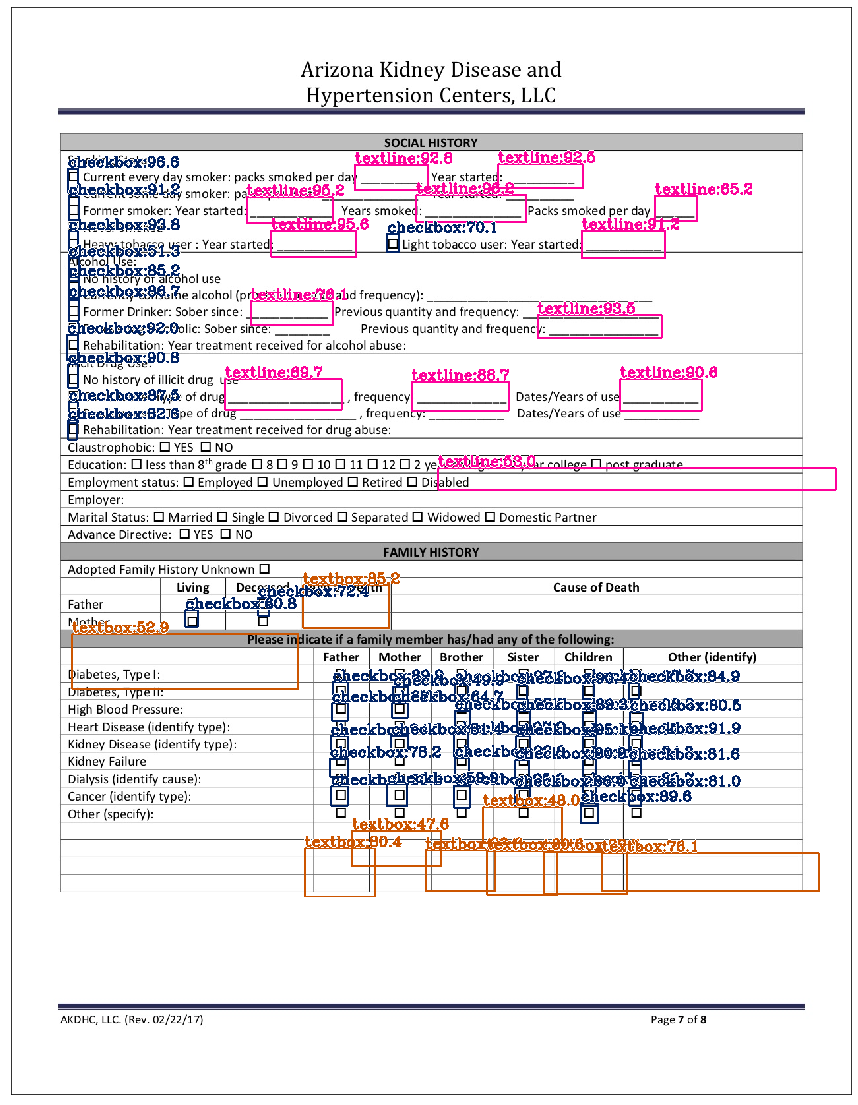

In [13]:
detect("AKDHC_New_Patient_Packet_1.jpg")